# intake-esm

- <https://data-infrastructure-services.gitlab-pages.dkrz.de/tutorials-and-use-cases>
- <https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/>
- <https://intake-esm.readthedocs.io/>
- <https://github.com/intake/intake-esm>
- <https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html>
- <https://intake.readthedocs.io/>

In [1]:
# import libraries
import json
import os
from datetime import datetime, timezone
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import pooch
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-02-21 14:10:17.414928+00:00


In [3]:
DATA_DIR_BASE = os.path.join("data", "EURO-CORDEX")

In [4]:
os.makedirs(DATA_DIR_BASE, exist_ok=True)

In [5]:
# Cork Airport met station coords
LON = -8.48611
LAT = 51.84722

In [6]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [7]:
timerange = [
    "19710101-19751231",
    "19760101-19801231",
    "19810101-19851231",
    "19860101-19901231",
    "19910101-19951231",
    "19960101-20001231",
    "20010101-20051231",
    "20360101-20401231",
    "20410101-20451231",
    "20460101-20501231",
    "20510101-20551231",
    "20560101-20601231",
    "20610101-20651231",
    "20660101-20701231"
]

In [8]:
# add additional time ranges for the MOHC datasets, which use a 360-day year
timerange = timerange + [t.replace("1231", "1230") for t in timerange]

In [11]:
variables = ["evspsblpot", "pr", "rsds", "tas"]

In [12]:
driving_model_id = [
    "CNRM-CERFACS-CNRM-CM5",
    "ICHEC-EC-EARTH",
    "MPI-M-MPI-ESM-LR",
    "MOHC-HadGEM2-ES"
]

## Create local catalogue

In [13]:
dkrz_cat = intake.open_catalog(["https://dkrz.de/s/intake"])

In [14]:
server = dkrz_cat._entries["dkrz_cordex_disk"]._open_args["esmcol_obj"]

In [15]:
server

'https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/-/raw/master/esm-collections/cloud-access/dkrz_cordex_disk.json'

In [16]:
dkrz_cordex = intake.open_esm_datastore(
    server,
    read_csv_kwargs={"dtype": {"time_min": "string", "time_max": "string"}}
)

In [17]:
# download data if necessary
FILE_NAME = "dkrz_cordex_disk.json"
KNOWN_HASH = None
if not os.path.isfile(os.path.join(DATA_DIR_BASE, FILE_NAME)):
    pooch.retrieve(
        url=server,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=DATA_DIR_BASE
    )

    with open(
        os.path.join(DATA_DIR_BASE, f"{FILE_NAME[:-5]}.txt"),
        "w", encoding="utf-8"
    ) as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {server}"
        )

In [18]:
# keep data for the relevant variables and time ranges
query = {
    "CORDEX_domain": "EUR-11",
    "experiment_id": ["historical", "rcp45", "rcp85"],
    "frequency": "day",
    "variable_id": variables,
    "time_range": timerange,
    "model_id": "SMHI-RCA4",
    "driving_model_id": driving_model_id,
    "member": ["r1i1p1", "r12i1p1"]
}

In [19]:
cordex_eur11 = dkrz_cordex.search(**query)

In [20]:
cordex_eur11

,unique
project,1
product_id,1
CORDEX_domain,1
institute_id,1
driving_model_id,4
experiment_id,3
member,2
model_id,1
rcm_version_id,2
frequency,1


In [21]:
cordex_eur11.df.shape

(462, 27)

In [22]:
list(cordex_eur11.df)

['project',
 'product_id',
 'CORDEX_domain',
 'institute_id',
 'driving_model_id',
 'experiment_id',
 'member',
 'model_id',
 'rcm_version_id',
 'frequency',
 'variable_id',
 'version',
 'time_range',
 'uri',
 'institution_id',
 'source_id',
 'simulation_id',
 'grid_label',
 'grid_id',
 'time_reduction',
 'realm',
 'level_type',
 'time_min',
 'time_max',
 'path',
 'format',
 'opendap_url']

In [23]:
cordex_eur11.df.head()

,project,product_id,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,...,grid_label,grid_id,time_reduction,realm,level_type,time_min,time_max,path,format,opendap_url
0,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,None,19710101,19751231,/work/kd0956/CORDEX/data/cordex/output/EUR-11/...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...
1,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,None,19760101,19801231,/work/kd0956/CORDEX/data/cordex/output/EUR-11/...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...
2,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,None,19810101,19851231,/work/kd0956/CORDEX/data/cordex/output/EUR-11/...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...
3,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,None,19860101,19901231,/work/kd0956/CORDEX/data/cordex/output/EUR-11/...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...
4,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,None,19910101,19951231,/work/kd0956/CORDEX/data/cordex/output/EUR-11/...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...


In [24]:
# drop v1 of MPI-M-MPI-ESM-LR outputs
cordex_eur11_df = cordex_eur11.df.drop(
    cordex_eur11.df[
        (cordex_eur11.df["driving_model_id"] == "MPI-M-MPI-ESM-LR") &
        (cordex_eur11.df["rcm_version_id"] == "v1")
    ].index
)

In [25]:
# keep only r12i1p1 outputs of ICHEC-EC-EARTH
cordex_eur11_df = cordex_eur11_df.drop(
    cordex_eur11_df[
        (cordex_eur11_df["driving_model_id"] == "ICHEC-EC-EARTH") &
        (cordex_eur11_df["member"] == "r1i1p1")
    ].index
)

In [26]:
# extract driving model name, without the institution
cordex_eur11_df["driving_model"] = cordex_eur11_df["driving_model_id"].replace(
    to_replace={
        "CNRM-CERFACS-CNRM-CM5": "CNRM-CM5",
        "ICHEC-EC-EARTH": "EC-EARTH",
        "MOHC-HadGEM2-ES": "HadGEM2-ES",
        "MPI-M-MPI-ESM-LR": "MPI-ESM-LR"
    }
)

In [27]:
# replace URI to path to downloaded data
cordex_eur11_df["uri"] = (
    DATA_DIR_BASE + os.sep +
    "RCA4" + os.sep +
    cordex_eur11_df["experiment_id"] + os.sep +
    cordex_eur11_df["driving_model"] + os.sep +
    cordex_eur11_df["uri"].str.split("/").str[-1]
)

cordex_eur11_df["path"] = cordex_eur11_df["uri"]

In [28]:
cordex_eur11_df.head()

,project,product_id,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,...,grid_id,time_reduction,realm,level_type,time_min,time_max,path,format,opendap_url,driving_model
0,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19710101,19751231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
1,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19760101,19801231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
2,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19810101,19851231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
3,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19860101,19901231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
4,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19910101,19951231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5


In [29]:
cordex_eur11_df.shape

(336, 28)

In [30]:
CSV_FILE_PATH = os.path.join(DATA_DIR_BASE, "eurocordex_eur11_catalogue.csv")

In [31]:
cordex_eur11_df.to_csv(CSV_FILE_PATH, index=False)

In [32]:
JSON_FILE_PATH = os.path.join(DATA_DIR_BASE, "dkrz_cordex_disk.json")

In [33]:
# modify the JSON catalogue
with open(JSON_FILE_PATH, encoding="utf-8") as json_file:
    cordex_eur11_cat = json.load(json_file)
    json_file.close()

In [34]:
GITHUB_CSV_LINK = (
    "https://raw.githubusercontent.com/ClimAg/data/main/eurocordex/"
    "eurocordex_eur11_catalogue.csv"
)

cordex_eur11_cat["catalog_file"] = GITHUB_CSV_LINK

In [35]:
cordex_eur11_cat["id"] = "eurocordex_eur11"

In [36]:
cordex_eur11_cat["description"] = (
    "This is an ESM collection for EURO-CORDEX data used in the ClimAg "
    "project. Data has been generated using the DKRZ intake-esm stores. "
    "Data is filtered for the EUR-11 CORDEX domain at the daily frequency, "
    "the historical (1976-2005) and future (rcp45, rcp85) (2041-2070) "
    "experiments, and the following variables: " + ", ".join(variables) +
    ". The SMHI-RCA4 RCM and four GCMs (" + ", ".join(driving_model_id) +
    ") are the models used to generate these data. Last updated: " +
    str(datetime.now(tz=timezone.utc)) + "."
)

In [37]:
# save the modified JSON file
JSON_FILE_PATH = os.path.join(DATA_DIR_BASE, "eurocordex_eur11_local.json")

In [38]:
with open(JSON_FILE_PATH, "w", encoding="utf-8") as json_file:
    json.dump(cordex_eur11_cat, json_file, ensure_ascii=False, indent=4)

In [39]:
# create a copy that reads the CSV file from disk
cordex_eur11_cat["catalog_file"] = CSV_FILE_PATH
JSON_FILE_PATH = os.path.join(
    DATA_DIR_BASE, "eurocordex_eur11_local_disk.json"
)
with open(JSON_FILE_PATH, "w", encoding="utf-8") as json_file:
    json.dump(cordex_eur11_cat, json_file, ensure_ascii=False, indent=4)

## Testing the local catalogue

In [40]:
# JSON_FILE_PATH = (
#     "https://raw.githubusercontent.com/ClimAg/data/main/eurocordex/"
#     "eurocordex_eur11_local.json"
# )
JSON_FILE_PATH = os.path.join(
    DATA_DIR_BASE, "eurocordex_eur11_local_disk.json"
)

In [41]:
cordex_eur11_cat = intake.open_esm_datastore(JSON_FILE_PATH)

In [42]:
list(cordex_eur11_cat)

['EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.historical.day',
 'EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.rcp45.day',
 'EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4.rcp45.day',
 'EUR-11.CNRM-CERFACS-CNRM-CM5.SMHI.SMHI-RCA4.rcp45.day',
 'EUR-11.MOHC-HadGEM2-ES.SMHI.SMHI-RCA4.rcp85.day',
 'EUR-11.MOHC-HadGEM2-ES.SMHI.SMHI-RCA4.historical.day',
 'EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.rcp85.day',
 'EUR-11.MOHC-HadGEM2-ES.SMHI.SMHI-RCA4.rcp45.day',
 'EUR-11.CNRM-CERFACS-CNRM-CM5.SMHI.SMHI-RCA4.historical.day',
 'EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4.rcp85.day',
 'EUR-11.CNRM-CERFACS-CNRM-CM5.SMHI.SMHI-RCA4.rcp85.day',
 'EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4.historical.day']

In [43]:
cordex_eur11_cat

,unique
project,1
product_id,1
CORDEX_domain,1
institute_id,1
driving_model_id,4
experiment_id,3
member,2
model_id,1
rcm_version_id,2
frequency,1


In [44]:
cordex_eur11_cat.df.shape

(420, 28)

In [45]:
cordex_eur11_cat.df.head()

,project,product_id,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,...,grid_id,time_reduction,realm,level_type,time_min,time_max,path,format,opendap_url,driving_model
0,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19710101,19751231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
1,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19760101,19801231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
2,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19810101,19851231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
3,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19860101,19901231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5
4,CORDEX,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,19910101,19951231,data/EURO-CORDEX/RCA4/historical/CNRM-CM5/evsp...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,CNRM-CM5


### Read a subset (precipitation)

In [17]:
# filter data subset
query = dict(
    experiment_id="rcp85",
    variable_id="pr",
    driving_model_id="ICHEC-EC-EARTH"
)

In [18]:
cordex_eur11_pr = cordex_eur11_cat.search(**query)

In [19]:
cordex_eur11_pr

,unique
project,1
product_id,1
CORDEX_domain,1
institute_id,1
driving_model_id,1
experiment_id,1
member,1
model_id,1
rcm_version_id,1
frequency,1


In [20]:
cordex_eur11_pr.df

,project,product_id,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,...,grid_id,time_reduction,realm,level_type,time_min,time_max,path,format,opendap_url,driving_model
0,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20360101,20401231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
1,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20410101,20451231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
2,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20460101,20501231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
3,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20510101,20551231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
4,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20560101,20601231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
5,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20610101,20651231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH
6,CORDEX,output,EUR-11,SMHI,ICHEC-EC-EARTH,rcp85,r12i1p1,SMHI-RCA4,v1,day,...,None,None,None,None,20660101,20701231,data/EURO-CORDEX/RCA4/rcp85/EC-EARTH/pr_EUR-11...,netcdf,http://esgf1.dkrz.de/thredds/dodsC/cordex/EUR-...,EC-EARTH


In [21]:
pr = cordex_eur11_pr.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


In [22]:
pr = pr.popitem()[1]

In [23]:
pr

<xarray.Dataset>
Dimensions:       (rlat: 412, rlon: 424, member: 1, time: 12784, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon          (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
    rotated_pole  |S1 b''
  * time          (time) datetime64[ns] 2036-01-01T12:00:00 ... 2070-12-31T12...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(1827, 2), meta=np.ndarray>
  * member        (member) object 'r12i1p1'
Dimensions without coordinates: bnds
Data variables:
    pr            (member, time, rlat, rlon) float32 dask.array<chunksize=(1, 1827, 412, 424), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                        CF-1.4
    contact:                            rossby.cordex@smhi.se
    experiment:                         RCP8.5
    experiment_id:                      rcp85
    driving_experiment:                 ICHEC-EC-EARTH, rcp85, r12i1p1
    driving_model_id:                   ICHEC-EC-EARTH
    ...                                 ...
    intake_esm_attrs:time_reduction:    None
    intake_esm_attrs:realm:             None
    intake_esm_attrs:level_type:        None
    intake_esm_attrs:_data_format_:     netcdf
    intake_esm_attrs:driving_model:     EC-EARTH
    intake_esm_dataset_key:             EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4....

In [24]:
pr.rio.crs

CRS.from_wkt('GEOGCRS["undefined",BASEGEOGCRS["undefined",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],DERIVINGCONVERSION["Pole rotation (netCDF CF convention)",METHOD["Pole rotation (netCDF CF convention)"],PARAMETER["Grid north pole latitude (netCDF CF convention)",39.25,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["Grid north pole longitude (netCDF CF convention)",-162,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],PARAMETER["North pole grid longitude (netCDF CF convention)",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]]')

### Time subset

In [25]:
pr_50 = pr.sel(time="2055-06-21")

In [27]:
pr_50

<xarray.Dataset>
Dimensions:       (rlat: 412, rlon: 424, member: 1, time: 1, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon          (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
    rotated_pole  |S1 b''
  * time          (time) datetime64[ns] 2055-06-21T12:00:00
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
  * member        (member) object 'r12i1p1'
Dimensions without coordinates: bnds
Data variables:
    pr            (member, time, rlat, rlon) float32 dask.array<chunksize=(1, 1, 412, 424), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                        CF-1.4
    contact:                            rossby.cordex@smhi.se
    experiment:                         RCP8.5
    experiment_id:                      rcp85
    driving_experiment:                 ICHEC-EC-EARTH, rcp85, r12i1p1
    driving_model_id:                   ICHEC-EC-EARTH
    ...                                 ...
    intake_esm_attrs:time_reduction:    None
    intake_esm_attrs:realm:             None
    intake_esm_attrs:level_type:        None
    intake_esm_attrs:_data_format_:     netcdf
    intake_esm_attrs:driving_model:     EC-EARTH
    intake_esm_dataset_key:             EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4....

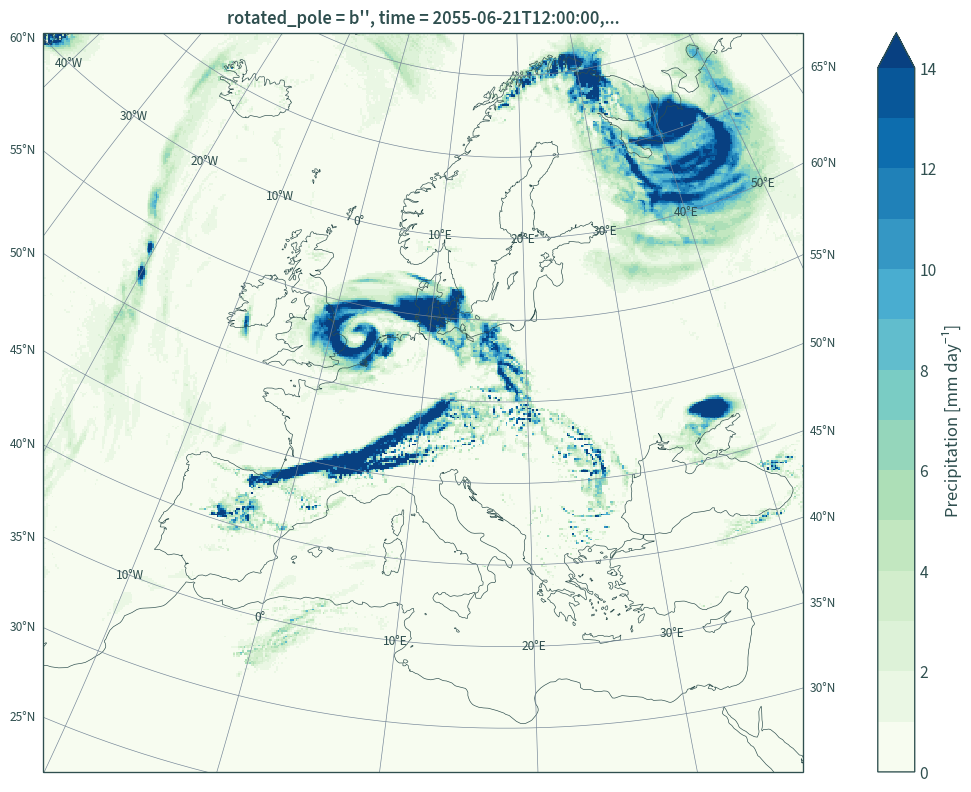

In [29]:
plot_transform = cplt.rotated_pole_transform(pr_50)
data_var = pr_50["pr"]  # variable name
plot_data = data_var * 60 * 60 * 24  # convert to mm day⁻¹
cbar_label = data_var.attrs["long_name"] + " [mm day⁻¹]"  # colorbar label

plt.figure(figsize=(20, 10))
ax = plt.axes(projection=plot_transform)

# specify gridline spacing and labels
ax.gridlines(
    draw_labels=True,
    xlocs=range(-180, 180, 10),
    ylocs=range(-90, 90, 5),
    color="lightslategrey",
    linewidth=.5
)

# plot data for the variable
plot_data.plot(
    ax=ax,
    cmap="GnBu",
    transform=plot_transform,
    x="rlon",
    y="rlat",
    cbar_kwargs=dict(label=cbar_label),
    levels=15,
    robust=True
)

# add boundaries
ax.coastlines(resolution="50m", color="darkslategrey", linewidth=.5)

plt.show()

### Point subset

In [30]:
cds = cplt.rotated_pole_point(data=pr, lon=LON, lat=LAT)

In [31]:
pr_ca = pr.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

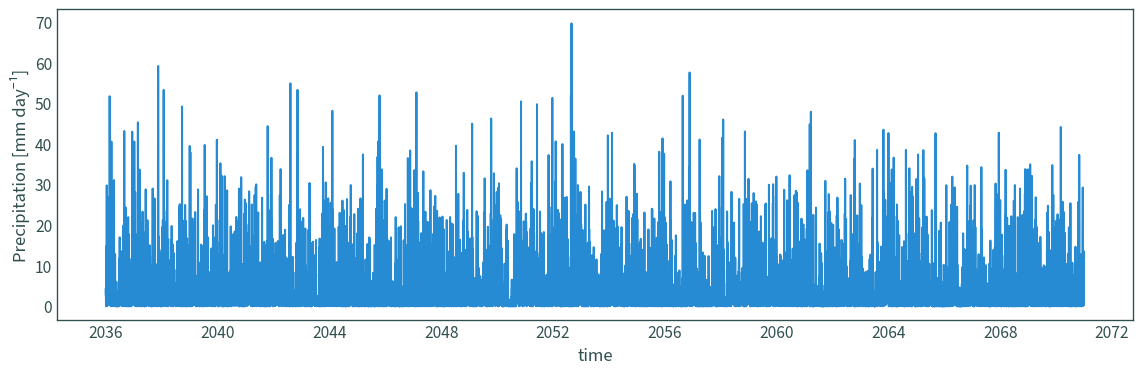

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(
    pr_ca["time"],
    pr_ca["pr"].values[0] * 60 * 60 * 24
)
plt.xlabel(pr_ca["time"].attrs["standard_name"])
plt.ylabel(pr_ca["pr"].attrs["long_name"] + " [mm day⁻¹]")
plt.tight_layout()
plt.show()

### Ireland subset

In [43]:
# clip to Ireland's boundary
pr_ie = pr_50.rio.clip(ie.buffer(500).to_crs(pr_50.rio.crs))

In [44]:
# find number of grid cells with data
len(
    pr_ie["pr"].values.flatten()[np.isfinite(pr_ie["pr"].values.flatten())]
)

575

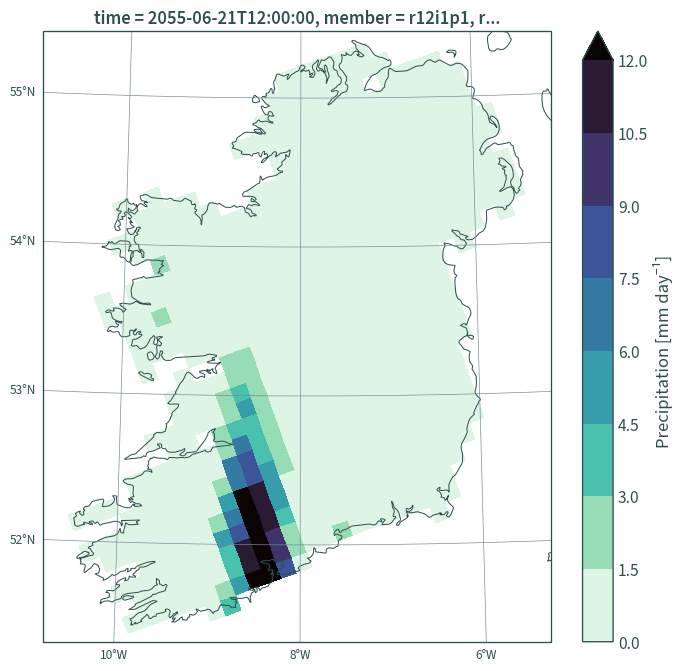

In [45]:
plot_transform = cplt.rotated_pole_transform(pr_ie)
data_var = pr_ie["pr"]  # extract variable name
plot_data = data_var * 60 * 60 * 24  # convert to mm day⁻¹
cbar_label = data_var.attrs["long_name"] + " [mm day⁻¹]"  # colorbar label

plt.figure(figsize=(7, 7))
ax = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
plot_data.plot(
    ax=ax,
    cmap=cplt.cmap_mako_r,
    transform=plot_transform,
    x="rlon",
    y="rlat",
    cbar_kwargs=dict(label=cbar_label),
    levels=10,
    robust=True
)

# add boundaries
ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)

plt.axis("equal")
plt.tight_layout()
plt.xlim(-1.5, 1.33)
plt.ylim(-2.05, 2.05)

ax.gridlines(
    draw_labels=dict(bottom="x", left="y"),
    xlocs=range(-180, 180, 2),
    ylocs=range(-90, 90, 1),
    color="lightslategrey",
    linewidth=.5,
    x_inline=False,
    y_inline=False
)

plt.show()